Recently during an [interview](https://www.youtube.com/watch?v=asfln1C0SnA) to promote the upcoming [PyMCon Web Series](https://pymcon.com/) (for which I am mentoring one of the first round of presenters), my friend [Ravin Kumar](https://ravinkumar.com/) kindly mentioned that a 2015 post of mine, [_Bayesian Survival Analysis in Python with PyMC3_](https://austinrochford.com/posts/2015-10-05-bayes-survival.html), drove a lot of his early interest in PyMC.  Ravin's comment caused me to revisit the post and realize how out of date it is.  In the seven years since it was published, there have been advances along many fronts:

1. [PyMC](https://www.pymc.io/welcome.html) is now on version 5; in 2015 I was using version 3 for that post.  Since that time Theano has been deprecated, PyMC considered alternate backends for some time, Aesara was forked from Theano, and finally PyTensor was forked from Aesara.  Not only has the backend for tensor computation evolved, the PyMC API has been improved and expanded significantly over the past seven years.
2. [ArviZ](https://python.arviz.org/en/stable/) [development](https://github.com/arviz-devs/arviz/graphs/contributors) technically started 2015, but didn't take off until 2018.  ArviZ has kept pace with theoretical developments in Bayesian model criticism and grown to be an integral part of my Bayesian modeling workflow.
3. [nutpie](https://github.com/pymc-devs/nutpie) [emerged](https://github.com/pymc-devs/nutpie/graphs/contributors) in the second half of 2022 as an extremely fast Rust implementation of adaptive HMC that can sample from the posteriors of Bayesian models specified with either PyMC or [Stan](https://mc-stan.org/).
4. [seaborn](https://seaborn.pydata.org/) recently released the [seaborn.objects](https://seaborn.pydata.org/tutorial/objects_interface.html) interface, an exciting development in bringing [grammar of graphics](https://www.amazon.com/Grammar-Graphics-Statistics-Computing/dp/0387245448)-style visualization to Python.
5. I have improved at least somewhat as a developer, modeler, and a writer since 2015 😊.

For all of these reasons, I thought it would be fun for me and perhap helpful to others to revisit this post and rework the example with updated techniques.

First we make the necessary Python imports and do some light configuration.

In [1]:
%matplotlib inline

In [2]:
from multipledispatch.dispatcher import AmbiguityWarning
from warnings import filterwarnings

In [3]:
import arviz as az
import lifelines as ll
from matplotlib import pyplot as plt
from matplotlib.ticker import NullLocator
import numpy as np
import nutpie
import pandas as pd
import pymc as pm
from pytensor import tensor as pt
import seaborn as sns
from seaborn import objects as so
from statsmodels.datasets import get_rdataset

In [4]:
filterwarnings("ignore", category=AmbiguityWarning)
filterwarnings("ignore", module="pymc", category=FutureWarning)

In [5]:
plt.rc("figure", figsize=(8, 6))
sns.set(color_codes=True)

We begin by loading the [`mastectomy`](https://vincentarelbundock.github.io/Rdatasets/doc/HSAUR/mastectomy.html) dataset from the [`HSAUR`](https://cran.r-project.org/web/packages/HSAUR/index.html) R package.

In [6]:
df = get_rdataset("mastectomy", package="HSAUR", cache=True).data
df["metastized"] = df["metastized"] == "yes"

In [7]:
df.head()

,time,event,metastized
0,23,True,False
1,47,True,False
2,69,True,False
3,70,False,False
4,100,False,False


In [8]:
df.tail()

,time,event,metastized
39,162,False,True
40,188,False,True
41,212,False,True
42,217,False,True
43,225,False,True


From the `HSAUR` [documentation](https://cran.r-project.org/web/packages/HSAUR/HSAUR.pdf), this dataset represents

> [s]urvival times in months after mastectomy of women with breast cancer. The cancers are classified as having metastized or not based on a histochemical marker.

In this data frame,

* `time` is the number of months since mastectomy,
* `event` indicates whether the woman died at the corresponding `time` (if `True`) or the observation was [censored](https://en.wikipedia.org/wiki/Survival_analysis#:~:text=Censoring%20%2F%20Censored%20observation%3A%20Censoring%20occurs,after%20the%20time%20of%20censoring.) (if `False`).  In the context of [survival analysis](https://en.wikipedia.org/wiki/Survival_analysis), censoring means that the woman survived past the corresponding time, but that her death was not observed.  Censoring (and its counterpart [truncation](https://www.usu.edu/math/jrstevens/biostat/projects2013/pres_LeftTruncation.pdf)) represents a fundamental challenge in survival analysis, and
* `metastized` indicates whether the woman's cancer had [metastized](https://en.wikipedia.org/wiki/Metastasis).

The following plot shows the time-to-event for each patient, along with whether or not the cancer had metastized and whether or not the patient's death was observed.

In [9]:
MONTHS_LABEL = "Months since mastectomy"

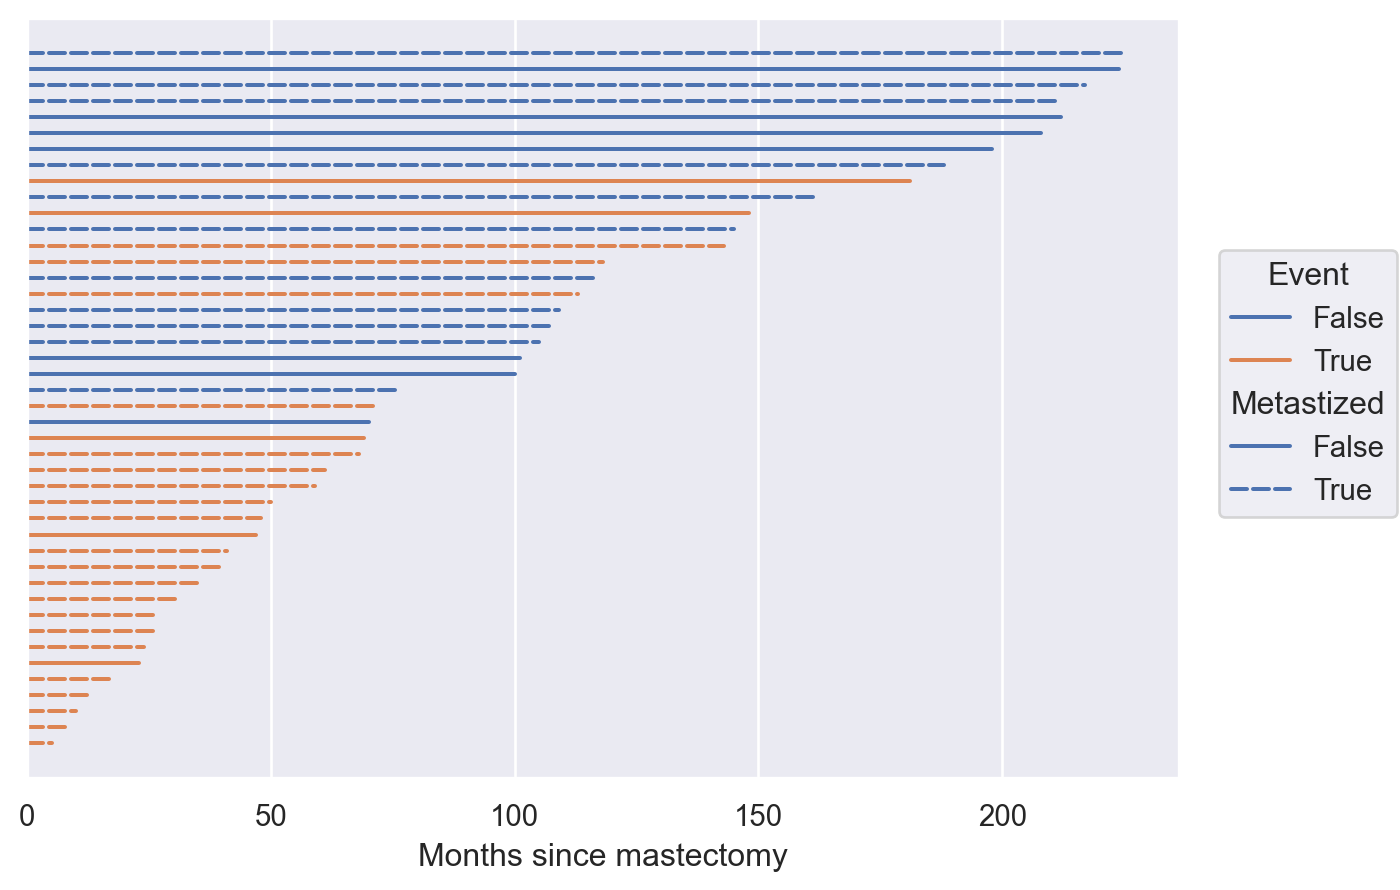

In [10]:
sorted_df = df.sort_values("time")

(so.Plot(sorted_df, x=0, y=np.arange(sorted_df.shape[0]),
         color="event", linestyle="metastized")
   .add(so.Dash(), so.Shift(x=sorted_df["time"] / 2), width="time")
   .scale(y=so.Continuous().tick(locator=NullLocator()),
          color=so.Nominal(), linestyle=so.Nominal())
   .limit(x=(0, None))
   .label(x=MONTHS_LABEL, y=None,
          color=str.capitalize, linestyle=str.capitalize))

We see that metastization is highly correlated with both short lifetime post-mastectomy and actual death.  The following contingency table confirms this observation.

In [11]:
df.pivot_table(values="time", index="metastized", columns="event",
               aggfunc=np.size, margins=True)

event,False,True,All
metastized,,,
False,7,5,12
True,11,21,32
All,18,26,44


## An improved crash course in survival analysis

When studying time-to-event data, especially in the presence of censoring (and/or truncation), [survival analysis](https://en.wikipedia.org/wiki/Survival_analysis) is the appropriate modeling framework.  As indicated by the name, survival analysis focuses on estimating the [survival function](https://en.wikipedia.org/wiki/Survival_function).  If $T$ is the time-to-event in question, the survival function is

$$S(t) = \mathbb{P}(T \geq t).$$

This focus on the survival function is important because for censored observations we only know that the time-to-event exceeds the recorded time.  The naive approach of treating cesnored observations as if the event occured at the time of censoring risks systematically underestimating the true average survival time, as we will illustrate later in this post.

Instead of working directly with the survival function, it is convenient to phrase our models in terms of the [cumulative hazard function](https://en.wikipedia.org/wiki/Survival_analysis#Hazard_function_and_cumulative_hazard_function).

$$\Lambda(t) = -\log S(t).$$  From this definition we see that $\Lambda(t) \geq 0$, $\Lambda(0) = 0$, and $\Lambda$ is nondecreasing.  Since we are working on a discrete timescale (we only know how many months the patient surived for, not exactly when they died or were censored), it is further convenient to decompose this cumulative hazard function into a sum of per-period hazards,

$$\Lambda(t) = \sum_{s \leq t} \lambda(s).$$

In the continuous-time case, this sum is replaced with an appropriate integral.

### The Cox proportional hazards model

With the cumulative hazard function decomposed as above, we can to introduce the [Cox proportional hazards model](https://en.wikipedia.org/wiki/Proportional_hazards_model#The_Cox_model).  Given predictors $\mathbf{x}$, this model treats $\lambda(t)$ as a log linear model,

$$\log \lambda(t\ |\ \mathbf{x}) = \alpha(t) + \beta \cdot \mathbf{x}.$$ 

This model is often expressed as

$$\lambda(t\ |\ \mathbf{x}) = \lambda_0(t) \cdot \exp(\beta \cdot \mathbf{x}),$$

where $\lambda_0(t) = \exp(\alpha(t)).$  This model has "proportional hazards" because, if $\mathbb{y}$ is the predictors for another patient,

$$\frac{\lambda(t\ |\ \mathbf{x})}{\lambda(t\ |\ \mathbf{y})} = \frac{\lambda_0(t) \cdot \exp(\beta \cdot \mathbf{x})}{\lambda_0(t) \cdot \exp(\beta \cdot \mathbf{y})} = \exp(\beta \cdot (\mathbf{x} - \mathbf{y}))$$

is independent of $t$.

## The Bayesian Cox model

With the mathematical form of our model specified, we can begin to implement it in Python using PyMC. First we extract the relevant columns from the data frame.  In our case,

$$x_i = \begin{cases}
0 & \text{if the }i\text{-th patient's cancer has not metastized} \\
1 & \text{if the }i\text{-th patient's cancer has metastized}
\end{cases}.$$

In [12]:
t = df["time"].values
event = df["event"].values
x = df["metastized"].values

We place a [hierarchical normal prior](https://www.bayesrulesbook.com/chapter-16.html#hierarchical-building-16) on $\alpha_t$ and a normal prior on $\beta$.

In [13]:
# the scale necessary to make a halfnormal distribution have unit variance
HALFNORMAL_SCALE = 1 / np.sqrt(1 - 2 / np.pi)

In [14]:
def noncentered_normal(name, *, dims, μ=None):
    if μ is None:
        μ = pm.Normal(f"μ_{name}", 0, 2.5)
    
    Δ = pm.Normal(f"Δ_{name}", 0, 1, dims=dims)
    σ = pm.HalfNormal(f"σ_{name}", 2.5 * HALFNORMAL_SCALE)
    
    return pm.Deterministic(name, μ + Δ * σ, dims=dims)

In [15]:
coords = {"metastized": np.array([False, True]), "time": np.arange(t.max() + 1)}

In [16]:
with pm.Model(coords=coords) as model:
    α = noncentered_normal("α", dims="time")
    β = pm.Normal("β", 0, 2.5)

We then define $\lambda(t) = \exp(\alpha(t) + \beta \cdot x).$

In [17]:
with model:
    λ = pt.exp(α[np.newaxis] + β * x[:, np.newaxis])

We could proceed by building

$$S(t\ |\ x) = \exp\left(-\sum_{s \leq t} \lambda(s\ |\ x)\right),$$

and using the fact that

$$\mathbb{P}(\text{died at }t\ |\ x) = S(t + 1\ |\ x) - S(t\ |\ x)$$

to tie the hazard function we have specified to our observations.  A simpler approach uses a classic result ([reference](https://grodri.github.io/glms/notes/c7.pdf) see §7.4.3) from the early 1980s, which is that this model is equivalent to the following [Poisson regression](https://en.wikipedia.org/wiki/Poisson_regression) model.

Let

$$d_{i, t} = \begin{cases}
1 & \text{if the }i\text{-th patient died in period }t \\
0 & \text{otherwise}
\end{cases}$$

indicate if the patient in question died in the $t$-th period and

$$e_{i, t} = \begin{cases}
1 & \text{if the }i\text{-th patient was alive at the beginning of period }t \\
0 & \text{otherwise}
\end{cases}$$

indicate if the patient was alive (exposed) at the beginning of the $t$-th period.  The Cox model is equivalent to a Poisson model for $d_{i, t}$ with mean $e_{i, t} \cdot \lambda(t\ |\ x_i).$

We now construct the arrays measuring exposure and indicating death.

In [18]:
exposed = np.full((df.shape[0], t.max() + 1), True, dtype=np.bool_)
np.put_along_axis(exposed, t[:, np.newaxis], False, axis=1)
exposed = np.minimum.accumulate(exposed, axis=1)

In [19]:
event_ = np.full_like(exposed, False, dtype=np.bool_)
np.put_along_axis(event_, t[:, np.newaxis] - 1, event[:, np.newaxis], axis=1)

We now add the observed Poisson-distributed event indicator to the model.

In [20]:
with model:
    pm.Poisson("event", exposed * λ, observed=event_)

Before we sample from the model's posterior distribution, we define a series of quantities that will allow us to easily visualize the posterior predictive survival functions for patients whose cancer had or had not metastized.  We do not use PyMC's built-in [posterior predictive sampling method](https://www.pymc.io/projects/docs/en/latest/api/generated/pymc.sample_posterior_predictive.html) here due to the way we constructed the observed variable using the equivalent Poisson model.  Adding these auxiliary quantities is more straightforward in this case.

In [21]:
with model:
    λ_pred = pt.exp(α[np.newaxis] + β * np.array([[0, 1]]).T)
    Λ_pred = λ_pred.cumsum(axis=1)
    sf_pred = pm.Deterministic("sf_pred", pt.exp(-Λ_pred), dims=("metastized", "time"))

Now we are ready to use nutpie to sample from the model's posterior distribution.

In [22]:
SEED = 123456789

In [23]:
trace = nutpie.sample(
    nutpie.compile_pymc_model(model),
    seed=SEED
)

With only a few divergences, we check the Gelman-Rubin $\hat{R}$ statistics to see if there were any obvious issues with sampling.

In [24]:
az.rhat(trace).max()

<xarray.Dataset>
Dimensions:    ()
Data variables:
    μ_α        float64 1.003
    Δ_α        float64 1.005
    σ_α_log__  float64 1.001
    β          float64 1.002
    σ_α        float64 1.001
    α          float64 1.003
    sf_pred    float64 1.003

All of the $\hat{R}$ statistics are below 1.01, so we see no obvious issues with sampling.

We now use seaborn to visualize the posterior predictive survival functions for patients in either state of metastization.

In [25]:
ALPHA = 0.05

so_ci = so.Perc([100 * ALPHA / 2, 100 * (1 - ALPHA / 2)])

In [26]:
PP_SF_LABEL = "Posterior predictive\nsurvival function"

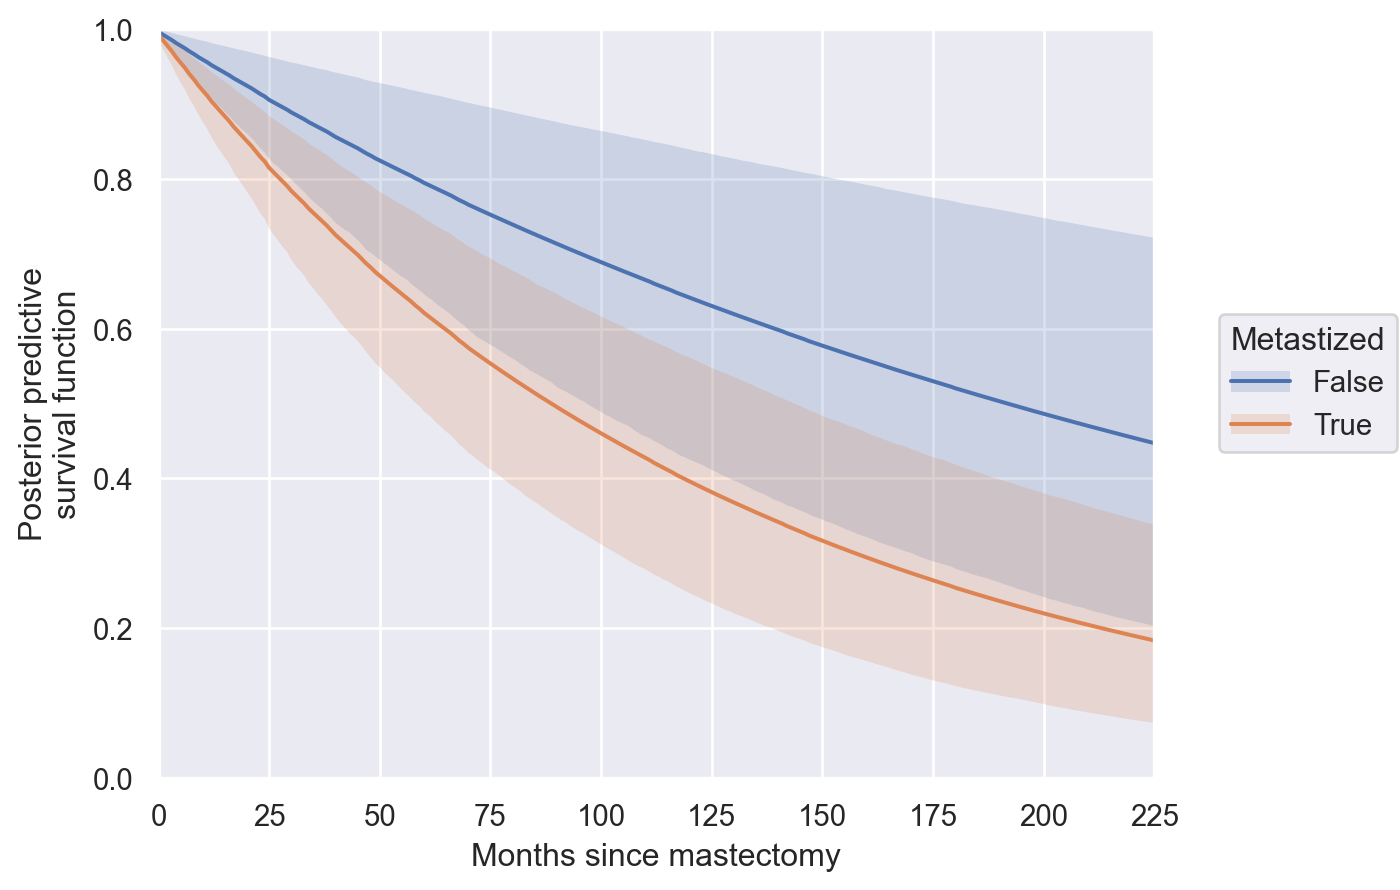

In [27]:
(so.Plot(trace.posterior["sf_pred"].to_dataframe(),
         x="time", y="sf_pred", color="metastized")
   .add(so.Line(), so.Agg())
   .add(so.Band(), so_ci)
   .scale(color=so.Nominal())
   .limit(x=(0, t.max()), y=(0, 1))
   .label(x=MONTHS_LABEL, y=PP_SF_LABEL, color=str.capitalize))

These posterior predictive survival functions look plausible; to confirm their correctness we compare them to predictions from Cox models fit using the [lifetimes](https://lifelines.readthedocs.io/en/latest/) package.

In [28]:
ll_model = ll.CoxPHFitter().fit(df, duration_col="time", event_col="event")

In [29]:
pred_df = pd.merge(
    trace.posterior["sf_pred"].to_dataframe(),
    ll_model.predict_survival_function(np.array([[False, True]]).T, times=np.arange(t.max() + 1))
            .rename(columns=bool)
            .rename_axis("time", axis=0)
            .rename_axis("metastized", axis=1)
            .stack()
            .rename("ll_pred"),
    left_index=True, right_index=True
)

The following plot adds the predictions from lifetimes to the posterior predictions from our model.

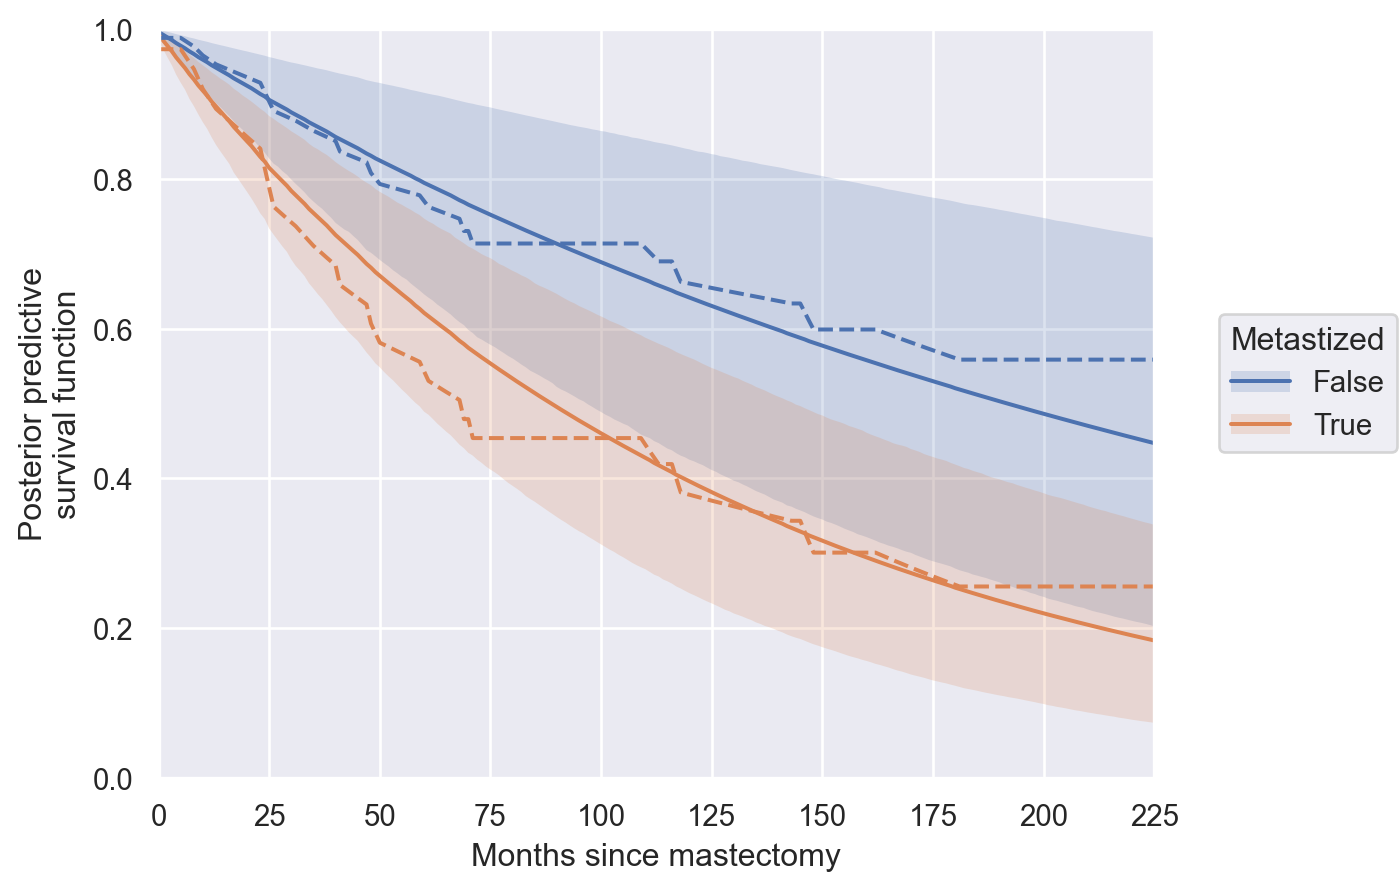

In [30]:
(so.Plot(pred_df,
         x="time", y="sf_pred", color="metastized")
   .add(so.Line(), so.Agg())
   .add(so.Band(), so_ci)
   .add(so.Line(linestyle="--"), so.Agg(func=lambda x: x[0]),
        y="ll_pred")
   .scale(color=so.Nominal())
   .limit(x=(0, t.max()), y=(0, 1))
   .label(x=MONTHS_LABEL, y=PP_SF_LABEL, color=str.capitalize))

The predictions are reasonably close (our Bayesian predictions are naturally more regularized towards the population mean than lifetimes'), which is reassuring.

We now return to a point briefly mentioned above, that naively estimating average lifetimes by ignoring censoring significantly underestimates the true average lifetime. First we use the [helpful fact](https://en.wikipedia.org/wiki/Survival_function#Properties) that

$$\mathbb{E}(T) = \sum_t S(t)$$

to calculate the posterior expected lifetime.

In [31]:
post_exp_life = trace.posterior["sf_pred"].sum(dim="time")

Now we naively estimate the expected lifetime two different ways.  First we take the average lifetime ignoring censoring (grouped according to metastization).

In [32]:
naive_life_df = (df.groupby("metastized")
                   ["time"]
                   .mean()
                   .rename("naive"))

Second we take the average lifetime of patients that did, in fact, die (grouped according to metastization).

In [33]:
naive_event_life_df = (df[df["event"]]
                         .groupby("metastized")
                         ["time"]
                         .mean()
                         .rename("naive_event"))

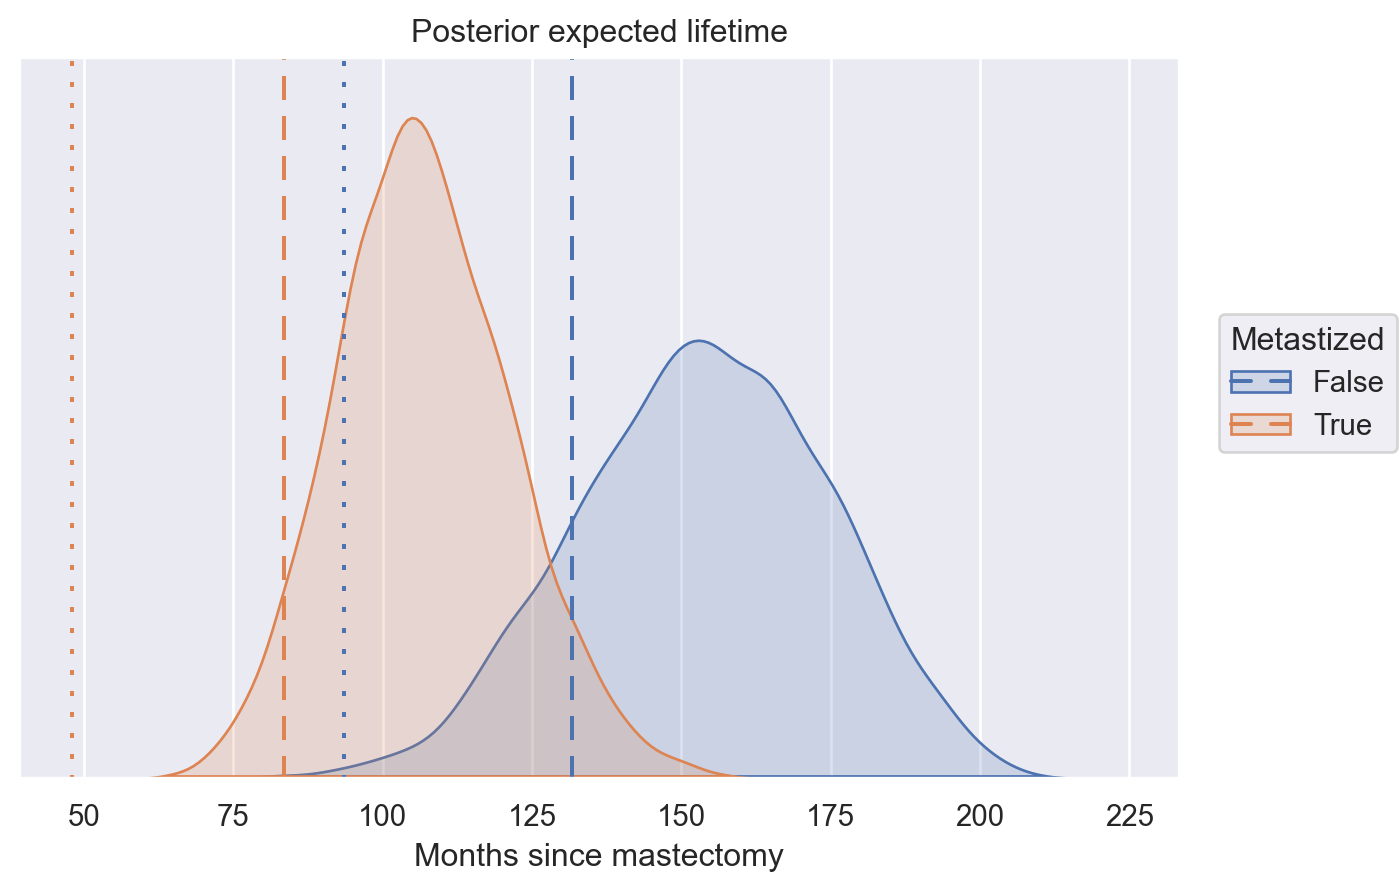

In [34]:
HEIGHT = 0.015

(so.Plot(post_exp_life.to_dataframe()
                      .join(naive_life_df)
                      .join(naive_event_life_df),
         x="sf_pred", color="metastized")
   .add(so.Area(), so.KDE())
   .add(so.Dash(width=HEIGHT, linestyle=(0, (5, 5))),
        x="naive", y=HEIGHT / 2, orient="y")
   .add(so.Dash(width=HEIGHT, linestyle=(0, (0.25, 5))),
        x="naive_event", y=HEIGHT / 2, orient="y")
   .scale(y=so.Continuous().tick(locator=NullLocator()),
          color=so.Nominal())
   .limit(y=(0, HEIGHT))
   .label(x=MONTHS_LABEL, title="Posterior expected lifetime",
          color=str.capitalize))

The first naive estimate is shown by the dashed horizontal lines and the second naive estimate is shown by the dotted lines.  (I am still learning my way around [seaborn's objects interface](https://seaborn.pydata.org/tutorial/objects_interface.html) and haven't figured out how to annotate those linestyles properly yet.)

We see that these estimates are significantly lower than the posterior expected lifetimes.

### Extensions of the Bayesian Cox model

There are many extensions of the Cox model that allow deviation from the proportional hazards assumption.  Two standard extensions are time-varying features and/or time-varying coefficients.  In this post we will build a model with time-varying coefficients, although our model is equally straightforward to modify to accommodate time-varying features.  To see that such a model no longer has proportional hazards, note that when $\beta(t)$ is a function if time,

$$\frac{\lambda(t\ |\ \mathbf{x})}{\lambda(t\ |\ \mathbf{y})} = \frac{\lambda_0(t) \cdot \exp(\beta(t) \cdot \mathbf{x})}{\lambda_0(t) \cdot \exp(\beta(t) \cdot \mathbf{y})} = \exp(\beta(t) \cdot (\mathbf{x} - \mathbf{y}),)$$

which still depends on $t$.  In the our case, time-varying effects might correspond to the hypothesis that metastization causes most patients to die quickly, but those patients whose that live longer have diminished extra risk due to metastization.

Thanks to the modularity of PyMC, it is easy to modify our model to include time-varying coefficients.  We place a random-walk prior with appropriately scaled hierarchical normal increments on $\beta(t)$.

In [35]:
with pm.Model(coords=coords) as tv_model:
    μ_β = pm.Normal("μ_β", 0, 2.5)
    β_inc = noncentered_normal("β_inc", μ=0, dims="time")
    β = pm.Deterministic("β", μ_β + (β_inc / np.sqrt(t.max() + 1)).cumsum(axis=0),
                         dims="time")

The rest of the model is specified almost exactly as before.

In [36]:
with tv_model:
    α = noncentered_normal("α", dims="time")
    
    λ = pt.exp(α[np.newaxis] + β[np.newaxis] * x[:, np.newaxis])
    pm.Poisson("event", exposed * λ, observed=event_)
    
    λ_pred = pt.exp(α[np.newaxis] + β * np.array([[0, 1]]).T)
    Λ_pred = λ_pred.cumsum(axis=1)
    sf_pred = pm.Deterministic("sf_pred", pt.exp(-Λ_pred), dims=("metastized", "time"))

We now sample from this model's posterior distribution.

In [37]:
tv_trace = nutpie.sample(
    nutpie.compile_pymc_model(tv_model),
    seed=SEED
)

There are a few more divergences, but they have not yet reached concerning levels. The Gelman-Rubin $\hat{R}$ statistics also indicate no obvious sampling issues.

In [38]:
az.rhat(tv_trace).max()

<xarray.Dataset>
Dimensions:        ()
Data variables:
    μ_β            float64 1.005
    Δ_β_inc        float64 1.004
    σ_β_inc_log__  float64 1.004
    μ_α            float64 1.003
    Δ_α            float64 1.004
    σ_α_log__      float64 1.003
    σ_β_inc        float64 1.004
    σ_α            float64 1.003
    β_inc          float64 1.006
    β              float64 1.005
    α              float64 1.003
    sf_pred        float64 1.002

The following plot of $\beta(t)$ somewhat bears out our hypothesis, as the additional hazard due to metastization decreases somewhat over time (the credible interval is quite wide though).

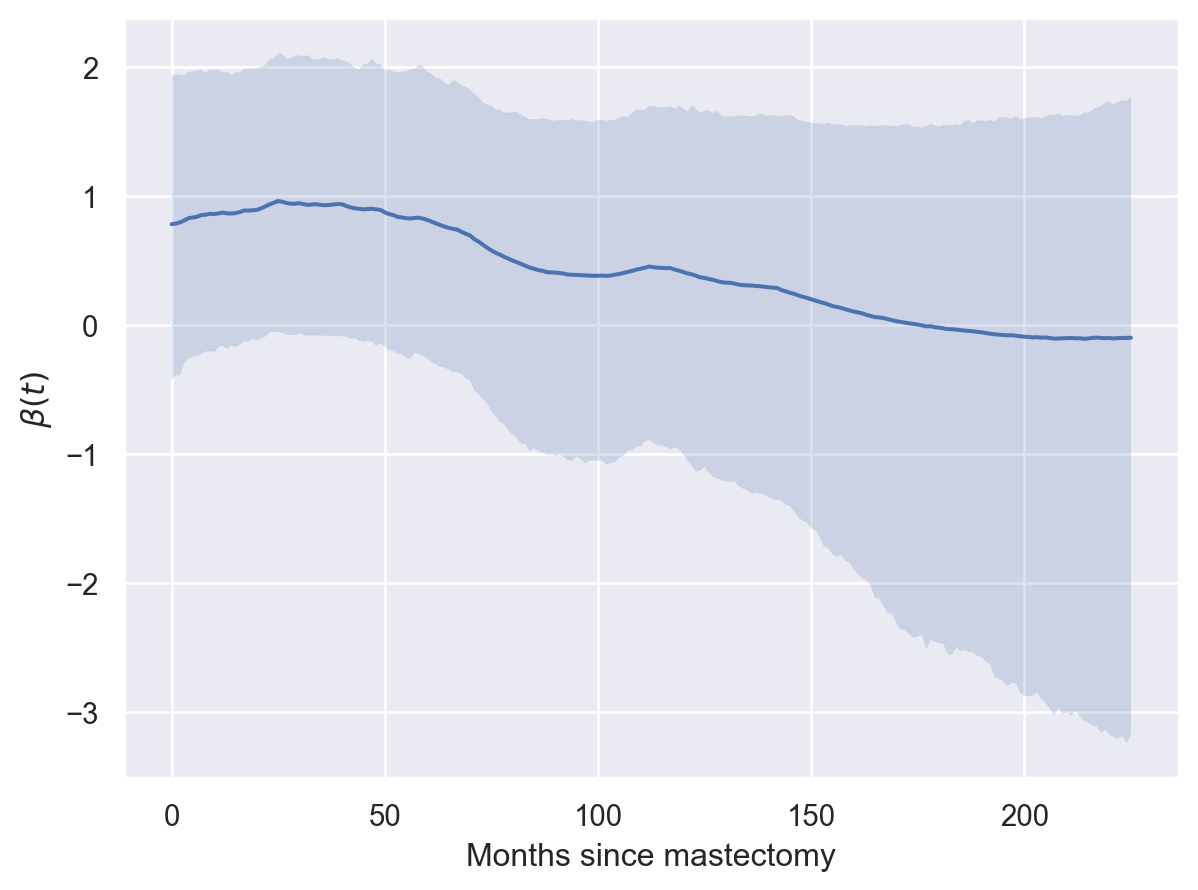

In [39]:
(so.Plot(tv_trace.posterior["β"].to_dataframe(),
         x="time", y="β")
   .add(so.Line(), so.Agg())
   .add(so.Band(), so_ci)
   .label(x=MONTHS_LABEL, y=r"$\beta(t)$"))

We see the effect of these time-varying coefficients on the posterior predictive survival functions below (the dashed lines and credible intervals are for the time-varying model).

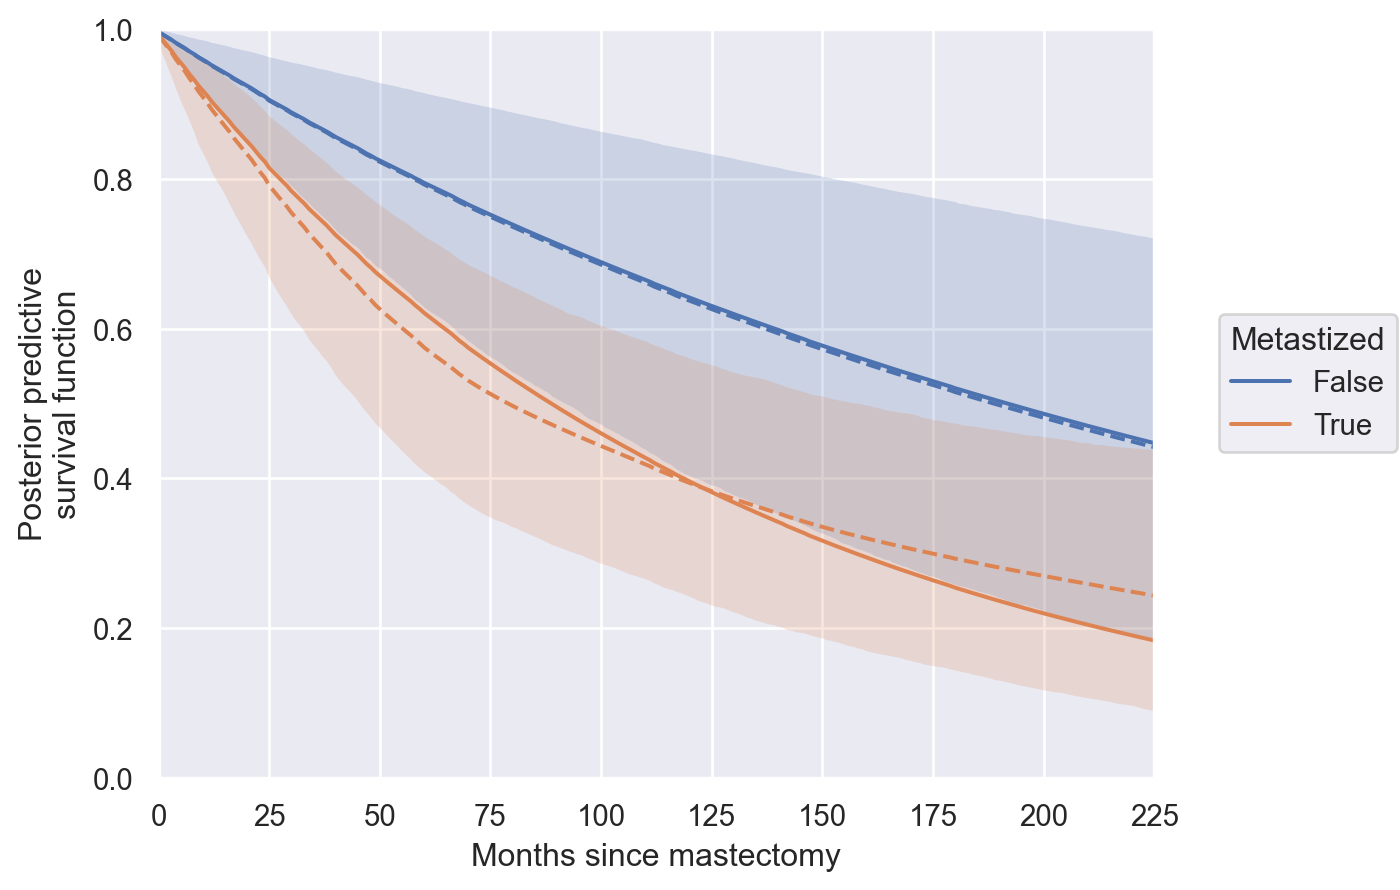

In [40]:
(so.Plot(trace.posterior["sf_pred"].to_dataframe(),
         x="time", y="sf_pred", color="metastized")
   .add(so.Line(), so.Agg())
   .add(so.Line(linestyle="--"), so.Agg(), 
        data=tv_trace.posterior["sf_pred"].to_dataframe())
   .add(so.Band(), so_ci,
        data=tv_trace.posterior["sf_pred"].to_dataframe())
   .scale(color=so.Nominal())
   .limit(x=(0, t.max()), y=(0, 1))
   .label(x=MONTHS_LABEL, y=PP_SF_LABEL, color=str.capitalize))

This post is available as a Jupyter notebook [here](https://nbviewer.org/gist/AustinRochford/461c74db80833fdf4287ba91ee136b8f).

In [41]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Tue Jan 10 2023

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.7.0

numpy     : 1.23.5
pytensor  : 2.8.11
pymc      : 5.0.1
lifelines : 0.27.4
arviz     : 0.14.0
seaborn   : 0.12.2
pandas    : 1.5.2
matplotlib: 3.6.2
nutpie    : 0.5.1

